<a href="https://colab.research.google.com/github/1eetnals/PeopleAI-skin-disease/blob/main/peopleAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**People AI** 

> 비대면 피부병 진단 플랫폼(건선/습진, 곤지름/진주양구진 중심)                   
 > 바이오메디컬공학과 201900851 김수민, 201900931 김영주, 201902572 이수민



- 코드참조 : https://colab.research.google.com/github/fastai/fastbook/blob/master/02_production.ipynb

In [ ]:
# !pip install -Uqq fastbook: 모듈설치

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 25.7MB/s 
     |████████████████████████████████| 204kB 44.9MB/s 
     |████████████████████████████████| 1.2MB 54.1MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
     |████████████████████████████████| 61kB 10.6MB/s 
Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
from fastbook import *
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
from fastai.vision.widgets import *
import os

### **Data 불러오기**

In [ ]:
Disease_types = 'Psoriasis','Condyloma Acuminatum','Eczema','Pearly penile Papules, Normal' #Disease 종류 구분
path = Path('/content/drive/Shareddrives/AI/peopleAI') #data 를 불러올 경로설정(공유드라이브이용)

In [ ]:
fns = get_image_files(path) #경로를 통해 이미지를 가지고옴

###**Data 전처리 과정**

In [ ]:
Disease = DataBlock(
    blocks = (ImageBlock, CategoryBlock),   #기능변수(이미지) 및 대상변수 지정 
    get_items = get_image_files, #이미지인 기본항목을 검색하고 해당 경로의 모든 이미지 목록을 반환
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #유효성 검사setdata 의 20%를 무작위 분할을 사용하고, 동일한 분할을 얻기위해 시드 지정
    get_y=parent_label, #폴더의 이름을 레이블로 가져 오는 함수
    item_tfms=Resize(128)) #이미지의 크기를 조정하기 위한 전처리과정

In [ ]:
dls = Disease.dataloaders(path) #data load하고 dls 에 저장 

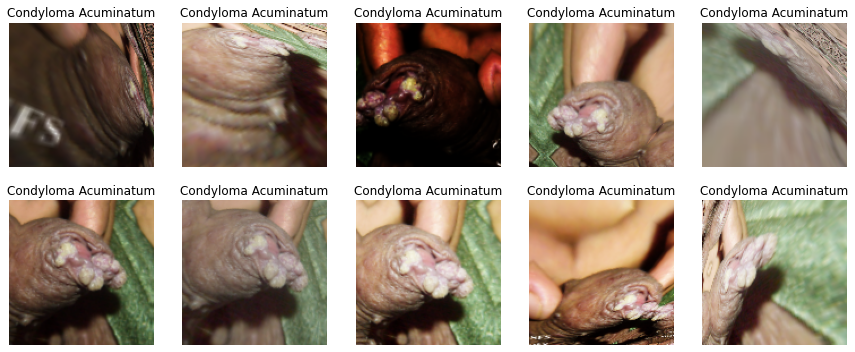

In [ ]:
Disease = Disease.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=3)) 
#전체 배치에 변형을 추가하여, 사진밝기변경, 기울기, 늘리기 및 찌그러짐의 변형 고려
dls = Disease.dataloaders(path)
dls.train.show_batch(max_n=10, nrows=2, unique=True) # 제한된 수의 이미지로 모델을 훈련하므로 데이터의 case를 늘리기 위해

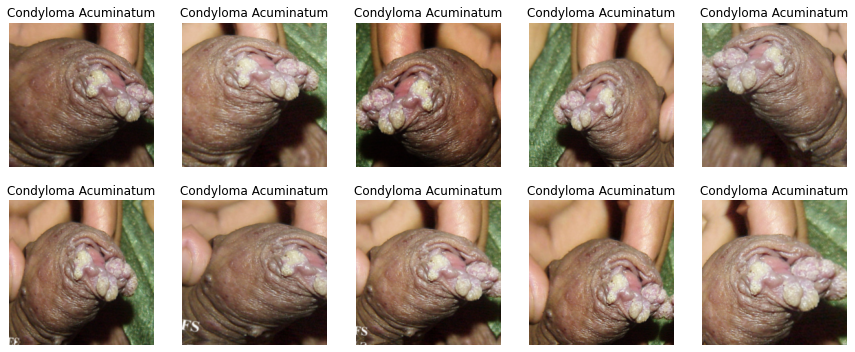

In [ ]:
Disease = Disease.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5), #224 픽셀로 원본사진을 자름
    batch_tfms=aug_transforms())
dls = Disease.dataloaders(path)
dls.train.show_batch(max_n = 10, nrows = 2, unique = True) #이미지 전처리

### **CNN 기반 학습**

In [ ]:
learn = cnn_learner(dls, densenet121, metrics=accuracy)
learn.fine_tune(18) #18개의 epoch

epoch,train_loss,valid_loss,accuracy,time
0,1.655230,0.721236,0.737179,00:31


epoch,train_loss,valid_loss,accuracy,time
0,0.990825,0.585073,0.769231,00:38
1,0.850329,0.479298,0.817308,00:38
2,0.747506,0.460944,0.817308,00:38
3,0.640817,0.446812,0.830128,00:38
4,0.538912,0.470755,0.815705,00:38
5,0.460489,0.455317,0.825321,00:38
6,0.388502,0.408074,0.849359,00:38
7,0.337689,0.338406,0.860577,00:38
8,0.291323,0.365167,0.863782,00:38
9,0.251830,0.328077,0.891026,00:38



**학습 결과 검증**

> 1) 시각화된 confusion matrix 확인  
> 2) 손실이 큰 데이터들을 확인하고, 재학습         
> 3) 모델의 결과 레이블 확인


 





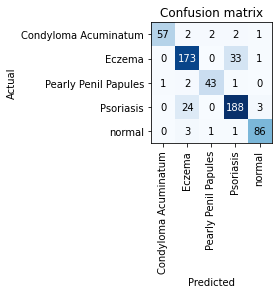

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix() #예측을 시각화, 실제레이블과 비교 (Actual, Predicted)

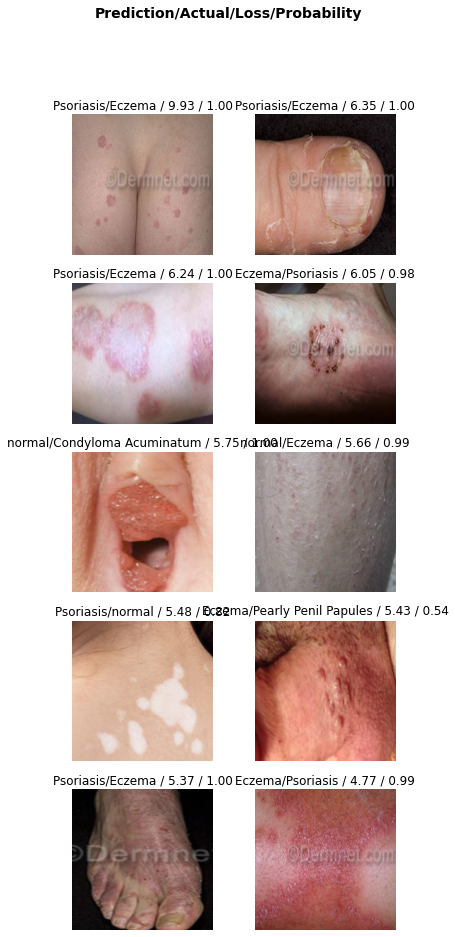

In [ ]:
interp.plot_top_losses(10, nrows=5) #손실이 큰 top data 를 5행 2열으로 출력

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner # 손실이 가장 큰 이미지를 레이블 직접 변경
#이때 변경할 필요가 없는 이미지는 <keep>상태 유지, 잘못 레이블된 것만 수정함

In [ ]:
for idx,disease in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), str(path/disease).split('.')[0] +"_fixed.jpg") #설정한 각 이미지를 올바른 디렉토리로 이동

In [ ]:
learn.export() #학습한 데이터를 다른 곳에 쓸 수 있게하기 위해서

In [ ]:
path = Path()
path.ls(file_exts='.pkl')  # 모델을 확장자 .pkl.로 설정

(#1) [Path('export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl') #모델을 로드하고 로드된 모델에 이미지를 전달하여 추론

In [ ]:
learn_inf.dls.vocab #모델의 레이블을 확인

['Condyloma Acuminatum', 'Eczema', 'Pearly Penil Papules', 'Psoriasis', 'normal']

### **사용자의 이미지 업로드**
 - **진단 결과 출력** 

In [ ]:
upload = widgets.FileUpload()
 #파일 업로드란 생성용 변수 지정
upload

FileUpload(value={}, description='Upload')

In [ ]:
img = PILImage.create(upload.data[-1]) #업로드된 이미지를 변수 img에 저장

In [ ]:
out_pl = widgets.Output() #업로드된 이미지 표시용 변수 지정
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img) #진단(예측)결과 저장

In [ ]:
lbl_pred = widgets.Label()
persentage = probs[pred_idx]*100
lbl_pred.value = f"[Prediction]: {pred} / [Probability]: {int(persentage)}%" #진단결과 & 정확도(%) 출력  

In [ ]:
if pred == 'normal':
  sentence = "정상입니다."

elif pred == 'Condyloma Acuminatum':
  sentence = "곤지름으로 예상됩니다.\n더욱 심해질 수 있으니, 병원에 내원해주세요."

elif pred == 'Eczema':
  sentence = """습진으로 예상됩니다.\n거친 비누 및 고농축 향기 나는 피부 제품 피하고, 너무 장시간 뜨거운 목욕이나 샤워를 하지 마세요.\n
  항생제 크림을 처방 하거나 항생제를 복용 해야 할 수도 있습니다.\n
  정확한 진단과 처방을 위하여 가까운 피부과를 방문하시길 권장합니다."""

elif pred == 'Psoriasis':
  sentence = """
  건선으로 예상됩니다.\r\nAnthralin, 살리실산, 합성 비타민 D 크림, 국소 레티노이드 등이 처방될 수 있습니다.\r\n
  정확한 진단과 처방을 위하여 가까운 피부과를 방문하시길 권장합니다. 
  """

elif pred == 'Pearly Penil Papules':
  sentence = "진주양구진으로 예상됩니다.\n전염성이 없으며, 건강에 해를 끼치는 것이 아니므로 불편함을 느끼지 않는다면 그대로 두셔도 무관합니다."

In [ ]:
btn_run = widgets.Button(description='Classify') #classify란 생성용 변수 지정

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f"[Prediction]: {pred} / [Probability]: {int(persentage)}%"

btn_run.on_click(on_click_classify)

In [ ]:
VBox([widgets.Label('진단결과'), out_pl,lbl_pred, widgets.Label(sentence)])
